# Convolutional Neural Network vs. Vision Transformer for Image Classification
David Dabreo, Robert Pianezza, Huzefa Paliwala, Siddhant Das, David Houle-Tymeczko

## Introduction
This project is based on the paper called *An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale* by Dosovitskiy et. al (2021), which introduced the use of transformers for image-based tasks. In the paper, they compare the performance of a few vision transformer (ViT) models to that of state of the art convoluational neural networks (CNNs) for image classification.

We attempt to replicate one of the experiments in the paper by evaluating the accuracy of ViT-base and Big Transfer (BiT) on the ImageNet dataset.

Note: We refer to the ILSVRC2012 ImageNet dataset as "ImageNet", which is a subset of the full dataset on 1000 classes.

### Environment Setup

The following libraries are used in this notebook:
- **NumPy**: For numerical computations.
- **Pandas**: For data manipulation.
- **Matplotlib and Seaborn**: For visualization.
- **PyTorch**: For model handling and GPU support.
- **Transformers**: For loading pre-trained models.

Ensure the necessary libraries are installed in your environment.



In [54]:
import numpy as np
import PIL
import torch
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import os
import pandas as pd
from transformers import ViTImageProcessor, ViTForImageClassification, BitImageProcessor, BitForImageClassification




### Loading Pre-Trained Models

We use two pre-trained models from the `transformers` library:
1. **ViT (Vision Transformer)**:
   - Based on the transformer architecture for images.
   - Processes input images as patches and learns relationships between patches.
   - Model: `google/vit-base-patch16-224`.

2. **BiT (Big Transfer)**:
   - A ResNet-based model trained on large datasets for better transfer learning.
   - Processes images using ResNet-like convolutional layers.
   - Model: `google/bit-50`.

Both models are loaded in evaluation mode and transferred to the appropriate device (CPU or GPU).

In [55]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Both ViT and BiT models classify images into one of 1000 classes from ImageNet
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
vit_model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224').eval().to(DEVICE)
feature_extractor = BitImageProcessor.from_pretrained("google/bit-50")
bit_model = BitForImageClassification.from_pretrained("google/bit-50").eval().to(DEVICE)
print(DEVICE)

cuda


### Dataset Classes

We define two custom PyTorch `Dataset` classes to handle image data:
- **ImageNetDataset**: Loads images and labels from the full ImageNet dataset, mapping class labels to indices using `LOC_synset_mapping.txt`.
- **TinyImageNetDataset**: Similar to `ImageNetDataset`, but adapted for the smaller TinyImageNet subset, using `val_annotations.txt` for labels.

Both classes support image preprocessing with optional transformations.


In [56]:
class ImageNetDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, annotations_file, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.labels = pd.read_csv(
            os.path.join(root_dir, annotations_file), 
            sep=',', header=0, usecols=[0, 1],
            names=['image', 'label'])
        self.labels['label'] = self.labels['label'].str.split().str[0]
        one_hot = pd.read_csv(
            os.path.join(root_dir, 'LOC_synset_mapping.txt'), 
            sep=' ', header=None, usecols=[0], names=['label']).reset_index().set_index('label')['index']
        self.labels['label'] = self.labels['label'].map(one_hot)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image_path = self.labels.loc[idx, 'image'] + '.JPEG'
        image = PIL.Image.open(os.path.join(self.root_dir, 'images', image_path)).convert('RGB')
        if self.transform:
            image = self.transform(images=image, return_tensors="pt")['pixel_values'].squeeze(0)
        return image, torch.tensor(self.labels.loc[idx, 'label'])

In [57]:
class TinyImageNetDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.labels = pd.read_csv(
            os.path.join(root_dir, 'val_annotations.txt'),
            sep='\t', header=None, usecols=[0, 1],
            names=['image', 'label'])
        self.labels['label'] = self.labels['label'].str.split().str[0]
        one_hot = pd.read_csv(
            os.path.join(root_dir, 'LOC_synset_mapping.txt'),
            sep=' ', header=None, usecols=[0], names=['label']).reset_index().set_index('label')['index']
        self.labels['label'] = self.labels['label'].map(one_hot)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image_path = self.labels.loc[idx, 'image']
        image = PIL.Image.open(os.path.join(
            self.root_dir, 'images', image_path)).convert('RGB')
        if self.transform:
            image = self.transform(images=image, return_tensors="pt")[
                'pixel_values'].squeeze(0)
        return image, torch.tensor(self.labels.loc[idx, 'label'])

### Utility Functions

The following helper functions streamline data handling and classification:
- **`classify`**: Predicts the class index of an input image using a specified model and processor.
- **`load_data`**: Loads image data from the TinyImageNet validation directory.
- **`load_annotations`**: Reads and processes the annotations file (`val_annotations.txt`) to map filenames to their corresponding class labels.

Annotations are further enriched with human-readable class names from the `words.txt` file.


In [58]:
# Returns the class index of the predicted class
def classify(model, processor, image):
    inputs = processor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class_idx = logits.argmax(-1).item()
    return predicted_class_idx


def load_data(annotations, directory=os.path.join('tiny_imagenet', 'val')):
    data = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.JPEG'):
                img = PIL.Image.open(os.path.join(root, file))
                data.append((img, ))
    return data

def load_annotations(directory=os.path.join('tiny_imagenet')):
    filepath = os.path.join(directory, 'val', 'val_annotations.txt')
    annotations = pd.read_csv(filepath, sep='\t', header=None) 
    annotations = annotations.loc[:, [0, 1]].rename(
        columns={0: 'filename', 1: 'wnid'})
    classes = pd.read_csv(os.path.join(directory, 'words.txt'), sep='\t', header=None).rename(columns={0: 'wnid', 1: 'class'})
    annotations['class'] = annotations['wnid'].map(classes.set_index('wnid')['class'])
    annotations.drop(columns=['wnid'], inplace=True)
    return annotations

annotations = load_annotations()

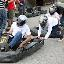

In [59]:
# imgs, labels = next(iter(dataloader))
data = TinyImageNetDataset(os.path.join('tiny_imagenet','val'))
img, label = data[0]
display(img)

In [60]:
# vit_model = vit_model.to(DEVICE)
# bit_model = bit_model.to(DEVICE)


# vit_pred_idx = classify(vit_model, processor, img)
# print("ViT prediction:", vit_model.config.id2label[vit_pred_idx])
# bit_pred_idx = classify(bit_model, feature_extractor, img)
# print("BiT prediction:", bit_model.config.id2label[bit_pred_idx])
# ground_truth = annotations.loc[0 , 'class']
# print("Ground truth:", ground_truth)

## Analysis

### Tiny ImageNet
- subset of ImageNet
- validation set contains 10,000 images and only 200 of the original 1000 classes

In [61]:
annotations.nunique(0)

filename    10000
class         200
dtype: int64

### Model Evaluation: Accuracy and Time Analysis

This section evaluates the performance of Vision Transformer (ViT) and Big Transfer (BiT) models on the Tiny ImageNet dataset:
1. **Dataloader Setup**:
   - `TinyImageNetDataset` is loaded using `DataLoader` for batch processing with a batch size of 64.
   - Each model uses its respective preprocessing (`processor` for ViT and `feature_extractor` for BiT).

2. **Accuracy Calculation**:
   - The `get_accuracy_and_save` function:
     - Computes the accuracy of the model by comparing predictions with ground truth labels.
     - Measures the time taken for evaluation.
     - Optionally saves predictions, labels, accuracy, and time in a pickle file for further analysis.

3. **Results**:
   - The accuracy and time taken by each model (ViT and BiT) are printed for comparison.


In [62]:
import time
data_dir = os.path.join('tiny_imagenet', 'val')
vit_dataloader = DataLoader(TinyImageNetDataset(data_dir, transform=processor), batch_size=64)
bit_dataloader = DataLoader(TinyImageNetDataset(data_dir, transform=feature_extractor), batch_size=64)

def get_accuracy_and_save(model, dataloader: DataLoader, device=torch.device('cpu'), filename=None):
    """
    Compute the accuracy of a model on a given DataLoader, 
    and optionally save the predictions and labels.
    
    Args:
        model: The model to evaluate.
        dataloader: DataLoader providing the dataset.
        device: The device on which to perform computations.
        filename: File to save predictions and labels (optional).
    
    Returns:
        Tuple containing accuracy and time taken for evaluation.
    """
    correct = 0
    all_preds = []
    all_labels = []
    total = len(dataloader.dataset)
    start = time.time()
    
    with torch.no_grad():
        for imgs, labels in dataloader:
            labels = labels.to(device)
            imgs = imgs.to(device)
            outputs = model(imgs)
            pred = outputs.logits.argmax(-1)
            correct += (pred == labels).sum().item()
            all_preds.append(pred.cpu().numpy())  # Move predictions to CPU
            all_labels.append(labels.cpu().numpy())
    
    accuracy = correct / total
    time_taken = time.time() - start
    # Optionally save predictions and labels
    if filename is not None:
        with open(filename, 'wb') as f:
            pickle.dump({'preds': np.concatenate(all_preds), 
                         'labels': np.concatenate(all_labels),
                         'accuracy': accuracy,
                        'time_taken': time_taken
                }, f)
        print(f"Saved results to {filename}")
    
    return accuracy, time_taken






## Results Analysis: Accuracy, Time, and Confusion Matrix

1. **Model Performance Evaluation**:
   - Accuracy and evaluation time for ViT and BiT models are computed using `get_accuracy_and_save`.
   - Results are saved in pickle files (`vit_tiny_imagenet.pkl` and `bit_tiny_imagenet.pkl`) for further analysis.

2. **Loading Saved Data**:
   - The `load_model_data` function retrieves predictions, labels, accuracy, and evaluation time from saved pickle files.
   - Data for both ViT and BiT models is loaded.

3. **Confusion Matrix Calculation**:
   - Predictions and labels for each model are used to compute confusion matrices (`confusion_matrix`).
   - These matrices provide insight into the classification performance by showing true positives, false positives, and other metrics.


In [63]:
#vit_accuracy, vit_time_taken = get_accuracy_and_save(vit_model, vit_dataloader, device=DEVICE, filename='vit_tiny_imagenet.pkl')
#bit_accuracy, bit_time_taken = get_accuracy_and_save(bit_model, bit_dataloader, device=DEVICE, filename='bit_tiny_imagenet.pkl')
# print(f"ViT Accuracy: {vit_accuracy*100:.2f}")
# print(f"Time taken: {vit_time_taken:.2f}s")
# print()
# print(f"BiT Accuracy: {bit_accuracy*100:.2f}")
# print(f"Time taken: {bit_time_taken:.2f}s")

In [64]:
def load_model_data(filename):
    with open(filename, 'rb') as f:
       data = pickle.load(f)
    return data['preds'], data['labels'], data['accuracy'], data['time_taken']


In [65]:


# Example: Load confusion matrix data for ViT and BiT
vit_preds, vit_labels, _, _ = load_model_data('Model_Data/vit_tiny_imagenet.pkl')
bit_preds, bit_labels, _, _ = load_model_data('Model_Data/bit_tiny_imagenet.pkl')

# Compute confusion matrices for both models
cm_vit = confusion_matrix(vit_labels, vit_preds)
cm_bit = confusion_matrix(bit_labels, bit_preds)



### Model Results Visualization

For both the **ViT** and **BiT** models, results were visualized using confusion matrices and bar graphs to evaluate accuracy and performance across datasets( **tinyimagenet** and **imagenet**).

- **Confusion Matrix**: Highlights correct predictions in **blue**, incorrect ones in **orange**, and emphasizes true class labels in **green**.
- **Bar Graphs**: Provide a clear comparison of **accuracy** and **inference time** between models.


In [66]:
class ConfusionMatrixPlotter:
    def __init__(self, true_classes, pred_classes, cm, num_classes_to_plot=50, model_name="Model"):
        """
        Initializes the confusion matrix plotter for a given model.

        Parameters:
        - true_classes: True class labels.
        - pred_classes: Predicted class labels.
        - cm: Confusion matrix to visualize.
        - num_classes_to_plot: Number of classes to plot (default: 50).
        - model_name: Name of the model (default: "Model").
        """
        self.true_classes = true_classes
        self.pred_classes = pred_classes
        self.cm = cm
        self.num_classes_to_plot = num_classes_to_plot
        self.model_name = model_name
        
        # Combine unique true and predicted classes for class names
        self.class_names = [label for label in np.unique(np.concatenate([self.true_classes, self.pred_classes]))]
        
    def plot(self):
        """
        Plots the confusion matrix for the given model.
        """
        # Filter confusion matrix
        cm_filtered = self.cm[:self.num_classes_to_plot, :self.num_classes_to_plot]

        # Create the plot
        plt.figure(figsize=(12, 10))
        sns.heatmap(
            cm_filtered, 
            annot=True, 
            fmt='d', 
            cmap='Blues', 
            xticklabels=self.class_names[:self.num_classes_to_plot], 
            yticklabels=self.class_names[:self.num_classes_to_plot], 
            cbar=False
        )

        # Customize the plot labels
        plt.title(f'{self.model_name} Confusion Matrix (First {self.num_classes_to_plot} Classes)')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.xticks(fontsize=8)
        plt.yticks(fontsize=8)
        plt.show()




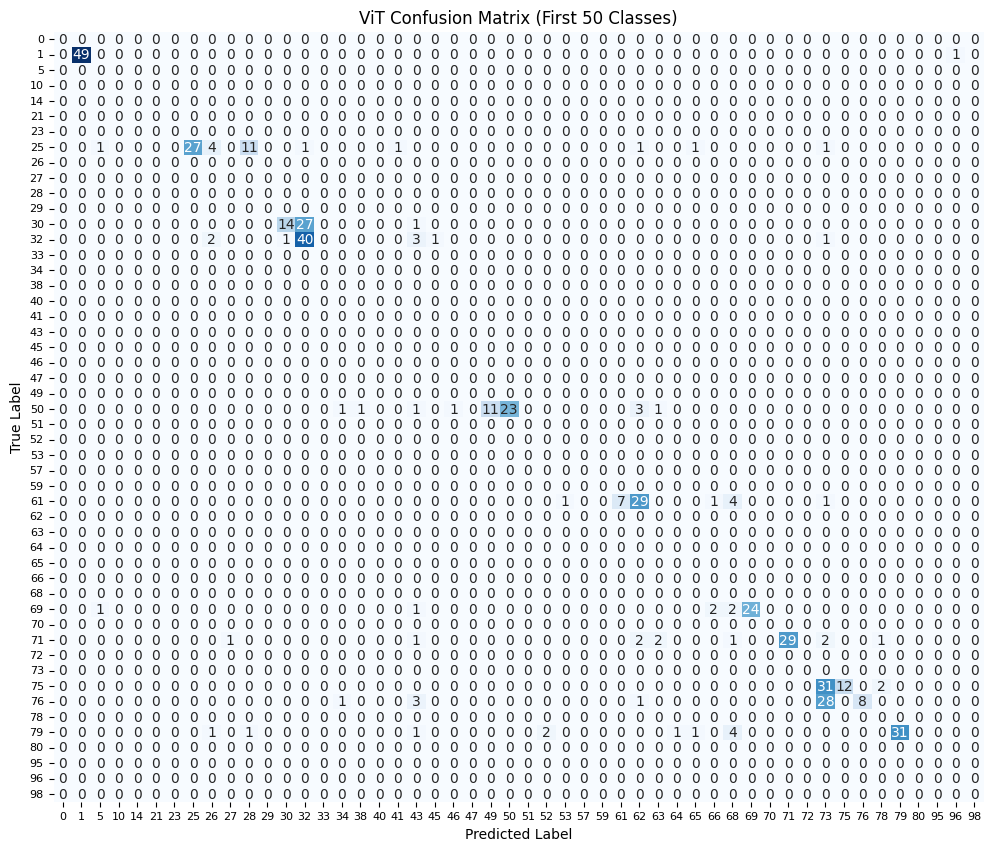

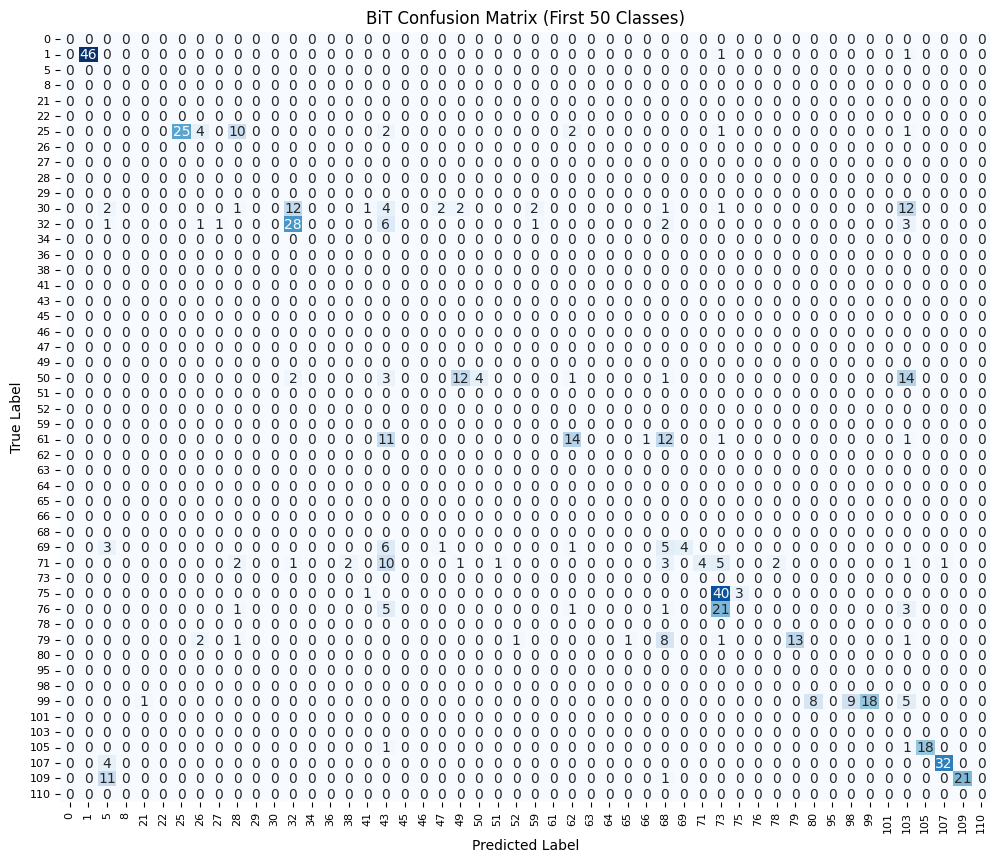

In [67]:
# Example usage for 
vit_true_classes = np.unique(vit_labels)
vit_pred_classes = np.unique(vit_preds)
bit_true_classes = np.unique(bit_labels)
bit_pred_classes = np.unique(bit_preds)

vit_plotter = ConfusionMatrixPlotter(vit_true_classes, vit_pred_classes, cm_vit, num_classes_to_plot=50, model_name="ViT")
vit_plotter.plot()

# Example usage for BiT
bit_plotter = ConfusionMatrixPlotter(bit_true_classes, bit_pred_classes, cm_bit, num_classes_to_plot=50, model_name="BiT")
bit_plotter.plot()

### Checking the Confusion Matrices

This function compares the true and predicted labels, identifying how many times the prediction matches the specified target class. It returns the total count of correct predictions for that class, providing insight into model performance at the class level.

In [68]:
def count_correct_preds_for_class(true_classes, pred_classes, target_class):
    # Get the indices where both the true class and predicted class match the target class
    correct_preds = [1 if true == pred == target_class else 0 for true, pred in zip(true_classes, pred_classes)]
    
    # Count the correct predictions for the given class
    correct_count = sum(correct_preds)
    
    return correct_count



In [69]:
target_class = 79
bit_correct_preds_for_class = count_correct_preds_for_class(bit_labels, bit_preds, target_class)
vit_correct_preds_for_class = count_correct_preds_for_class(vit_labels, vit_preds, target_class)
print(f"BIT: Number of correct predictions for class {target_class}: {bit_correct_preds_for_class}")
print(f"VIT: Number of correct predictions for class {target_class}: {vit_correct_preds_for_class}")

BIT: Number of correct predictions for class 79: 13
VIT: Number of correct predictions for class 79: 31


In [70]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(true_classes, pred_classes, cm, num_classes_to_plot=50, skip=1, model_name="Model"):
    """
    Visualizes the confusion matrix for a given model (ViT or BiT).

    Parameters:
    - true_classes: True class labels.
    - pred_classes: Predicted class labels.
    - cm: Confusion matrix to visualize.
    - num_classes_to_plot: Number of classes to plot (default: 50).
    - skip: Interval for plotting classes (default: 1).
    - model_name: Name of the model for the title (default: "Model").
    """
    # Get unique true and predicted classes
    true_classes = np.unique(true_classes)
    pred_classes = np.unique(pred_classes)
    
    # Combine unique true and predicted classes for class names
    class_names = [label for label in np.unique(np.concatenate([true_classes, pred_classes]))]
    
    # Filter rows based on true classes
    true_class_indices = [i for i, label in enumerate(class_names[:num_classes_to_plot:skip]) if label in true_classes]
    
    # Filter the confusion matrix
    cm_filtered = cm[np.ix_(true_class_indices, range(0, num_classes_to_plot, skip))]

    if cm_filtered.size > 0:
        filtered_pred_classes = [class_names[i] for i in true_class_indices]

        # Create a mask for matching rows and columns
        mask_match = np.zeros_like(cm_filtered, dtype=bool)
        for i, row_label in enumerate(filtered_pred_classes):
            for j, col_label in enumerate(pred_classes[:num_classes_to_plot:skip]):
                if row_label == col_label:
                    mask_match[i, j] = True

        plt.figure(figsize=(10, 10))

        ax = sns.heatmap(
            cm_filtered,
            annot=False,
            fmt="d",
            cmap="Blues",  # Custom colormap
            xticklabels=pred_classes[:num_classes_to_plot:skip],
            yticklabels=filtered_pred_classes,
            mask=~mask_match,  # Mask non-matching rows and columns
            cbar=False
        )

        # Highlight specific yticklabels
        yticklabels = ax.get_yticklabels()
        for label in yticklabels:
            class_label = label.get_text()  # No need to convert to int
            if class_label in map(str, true_classes):
                label.set_color("green")
                label.set_fontweight("bold")
                label.set_fontsize(12)
            else:
                label.set_alpha(0.5)

        # Highlight specific xticklabels
        xticklabels = ax.get_xticklabels()
        for label in xticklabels:
            class_label = label.get_text()  # No need to convert to int
            if class_label in map(str, true_classes):
                label.set_color("green")
                label.set_fontweight("bold")
                label.set_fontsize(12)
            else:
                label.set_alpha(0.5)

        # Add a second heatmap overlay to highlight incorrect predictions
        sns.heatmap(
            cm_filtered,
            annot=False,
            fmt="",
            cmap="Oranges",  # Different colormap for incorrect predictions
            xticklabels=pred_classes[:num_classes_to_plot:skip],
            yticklabels=filtered_pred_classes,
            mask=mask_match,  # Mask matching predictions
            cbar=False,
            linewidths=0.1,
        )

        # Add labels and title
        plt.title(f"{model_name} Confusion Matrix (First {num_classes_to_plot} classes)")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.xticks(fontsize=8)
        plt.yticks(fontsize=8)
        plt.show()
    else:
        print("The confusion matrix is empty or has invalid dimensions.")


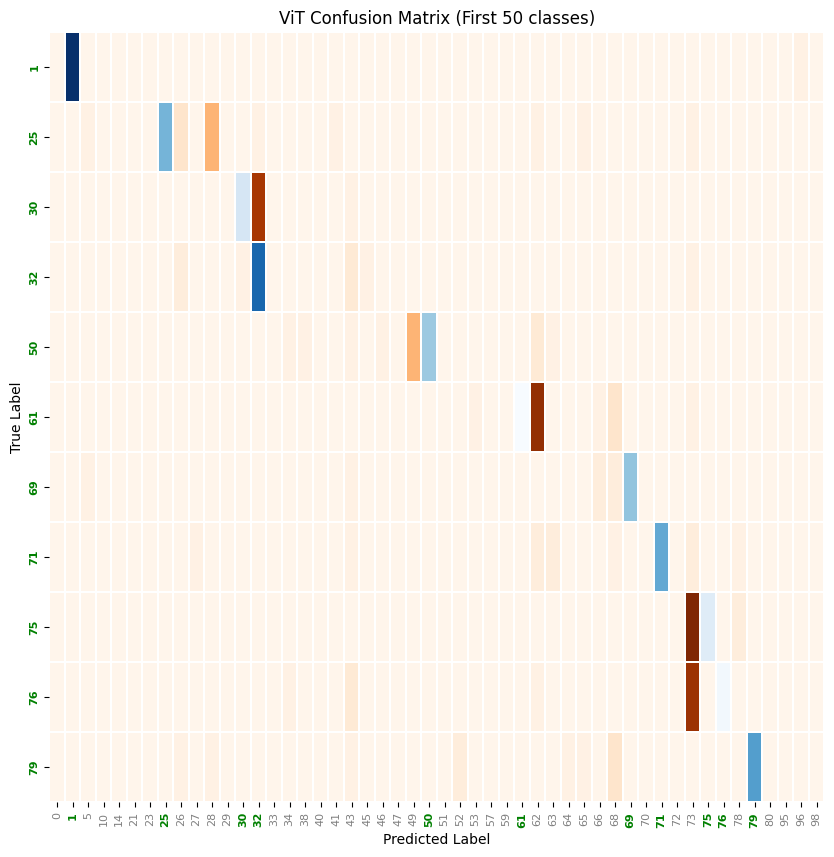

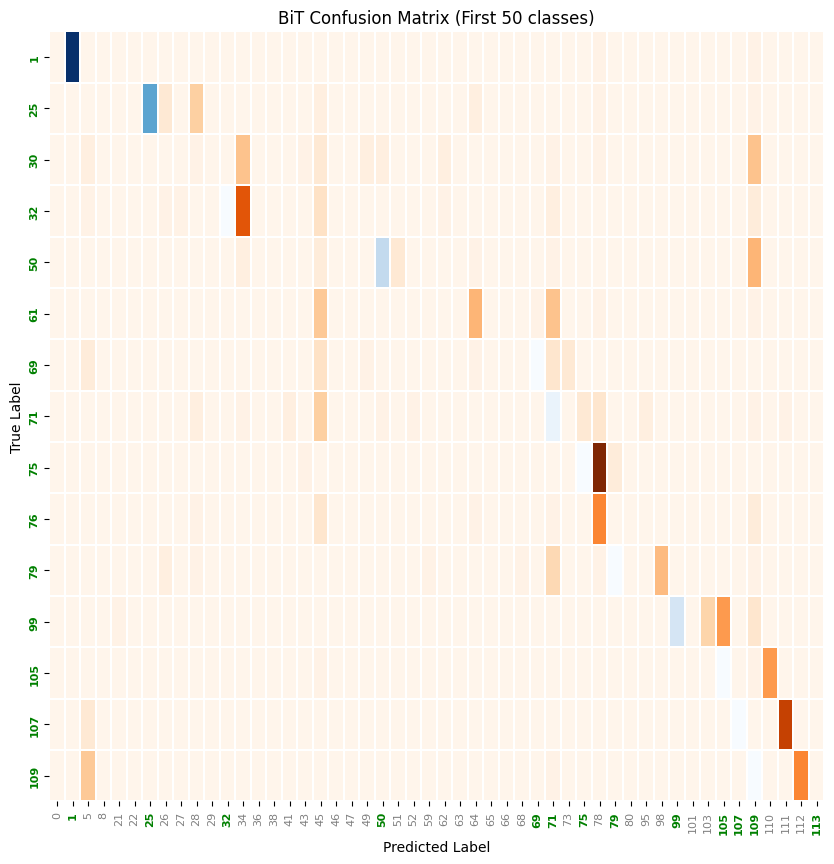

In [71]:
plot_confusion_matrix(vit_labels, vit_preds, cm_vit, num_classes_to_plot=50, model_name="ViT")
plot_confusion_matrix(bit_labels, bit_preds, cm_bit, num_classes_to_plot=50, model_name="BiT")


ViT Accuracy: 62.07%
Time taken: 44.57s

BiT Accuracy: 33.18%
Time taken: 109.76s



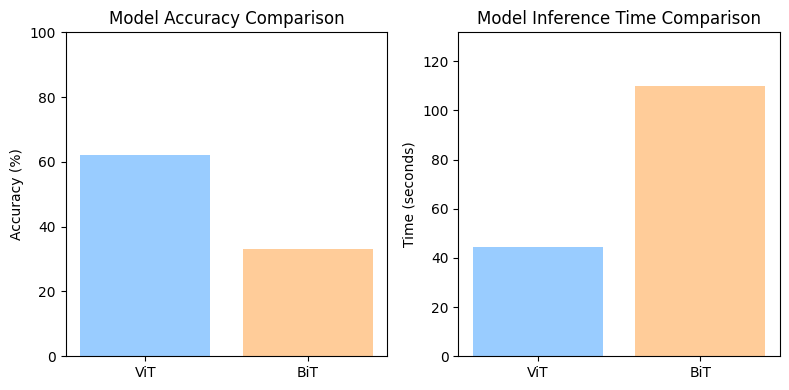

In [72]:

_, _, vit_accuracy, vit_time_taken = load_model_data('Model_Data/vit_tiny_imagenet.pkl')
_, _, bit_accuracy, bit_time_taken = load_model_data('Model_Data/bit_tiny_imagenet.pkl')
# Model names
models = ['ViT', 'BiT']

# Accuracy and time taken values
accuracies = [vit_accuracy * 100, bit_accuracy * 100]
times_taken = [vit_time_taken, bit_time_taken]


# Display results
for model, acc, time_taken in zip(['ViT', 'BiT'], [vit_accuracy * 100, bit_accuracy * 100], [vit_time_taken, bit_time_taken]):
    print(f"{model} Accuracy: {acc:.2f}%\nTime taken: {time_taken:.2f}s\n")

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
for i, (data, title, ylabel, ylim) in enumerate(zip([[vit_accuracy * 100, bit_accuracy * 100], [vit_time_taken, bit_time_taken]],
                                                   ['Model Accuracy Comparison', 'Model Inference Time Comparison'],
                                                   ['Accuracy (%)', 'Time (seconds)'],
                                                   [100, max([vit_time_taken, bit_time_taken]) * 1.2])):
    ax[i].bar(['ViT', 'BiT'], data, color=['#99CCFF', '#FFCC99'])
    ax[i].set_title(title)
    ax[i].set_ylabel(ylabel)
    ax[i].set_ylim(0, ylim)

plt.tight_layout()
plt.show()


### ImageNet
- validation set: 50,000 images split among 1000 classes
- we use the validation set because the test set does not have publically-available ground-truth labels
    - but we still want to avoid using images that the models were trained on

In [73]:
data_dir = 'imagenet'
annotations_file = 'LOC_val_solution.csv'
vit_dataloader = DataLoader(ImageNetDataset(
    data_dir, annotations_file, transform=processor), batch_size=64)
bit_dataloader = DataLoader(ImageNetDataset(
    data_dir, annotations_file, transform=feature_extractor), batch_size=64)




In [74]:
# vit_accuracy, vit_time_taken = get_accuracy_and_save(vit_model, vit_dataloader, device=DEVICE, filename='vit_imagenet.pkl')
# bit_accuracy, bit_time_taken = get_accuracy_and_save(bit_model, bit_dataloader, device=DEVICE, filename='bit_imagenet.pkl')

# print(f"ViT Accuracy: {vit_accuracy*100:.2f}")
# print(f"Time taken: {vit_time_taken:.2f}s")
# print()
# print(f"BiT Accuracy: {bit_accuracy*100:.2f}")
# print(f"Time taken: {bit_time_taken:.2f}s")

In [75]:
# Example: Load confusion matrix data for ViT and BiT
vit_preds, vit_labels, _, _ = load_model_data('Model_Data/vit_imagenet.pkl')
bit_preds, bit_labels, _, _ = load_model_data('Model_Data/bit_imagenet.pkl')

# Compute confusion matrices for both models
cm_vit = confusion_matrix(vit_labels, vit_preds)
cm_bit = confusion_matrix(bit_labels, bit_preds)

# Get unique labels from the true labels
unique_labels = np.unique(vit_labels)  # Using vit_labels, as an example
class_names = [f'{label}' for label in unique_labels]  # Replace with actual class names if available

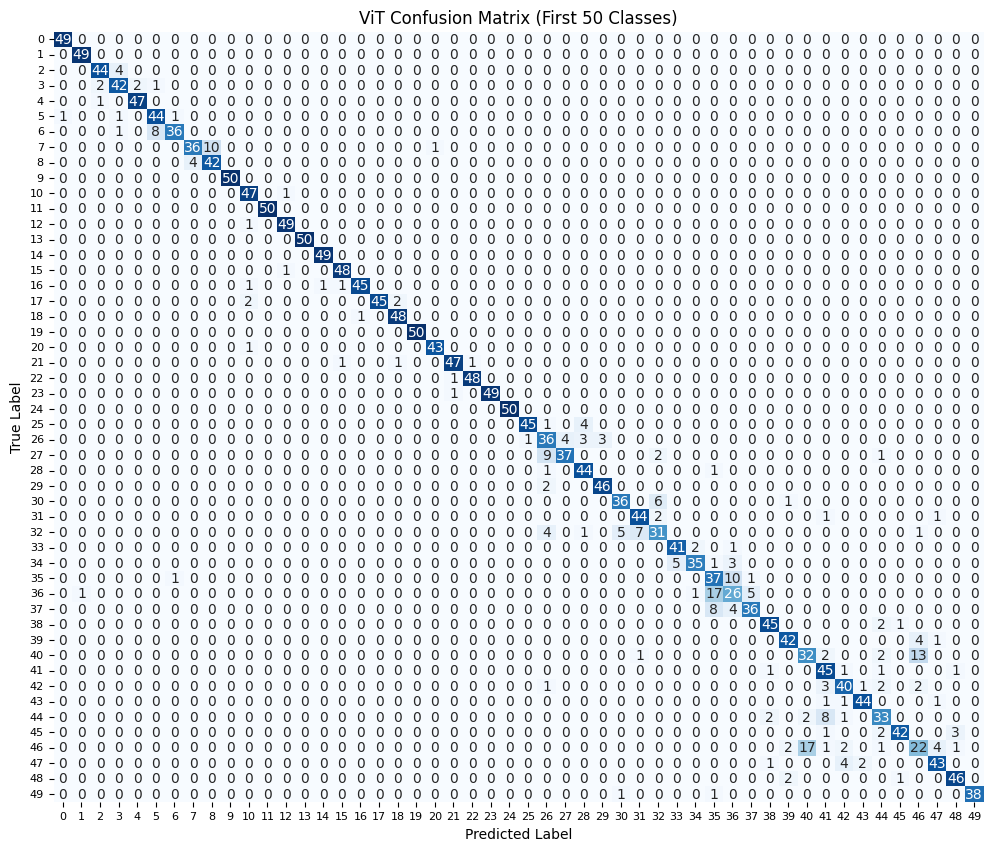

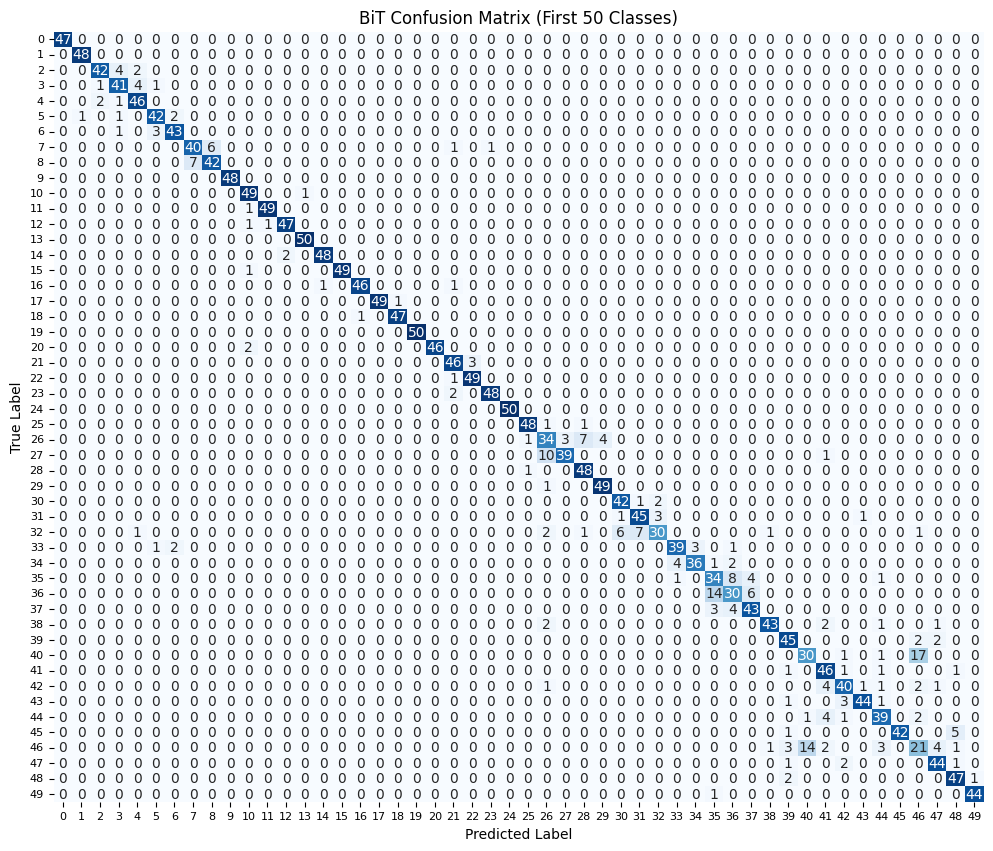

In [76]:
# Example usage for 
vit_true_classes = np.unique(vit_labels)
vit_pred_classes = np.unique(vit_preds)
bit_true_classes = np.unique(bit_labels)
bit_pred_classes = np.unique(bit_preds)

vit_plotter = ConfusionMatrixPlotter(vit_true_classes, vit_pred_classes, cm_vit, num_classes_to_plot=50, model_name="ViT")
vit_plotter.plot()

# Example usage for BiT
bit_plotter = ConfusionMatrixPlotter(bit_true_classes, bit_pred_classes, cm_bit, num_classes_to_plot=50, model_name="BiT")
bit_plotter.plot()

In [77]:
target_class = 46
bit_correct_preds_for_class = count_correct_preds_for_class(bit_labels, bit_preds, target_class)
vit_correct_preds_for_class = count_correct_preds_for_class(vit_labels, vit_preds, target_class)
print(f"BIT: Number of correct predictions for class {target_class}: {bit_correct_preds_for_class}")
print(f"VIT: Number of correct predictions for class {target_class}: {vit_correct_preds_for_class}")

BIT: Number of correct predictions for class 46: 21
VIT: Number of correct predictions for class 46: 22


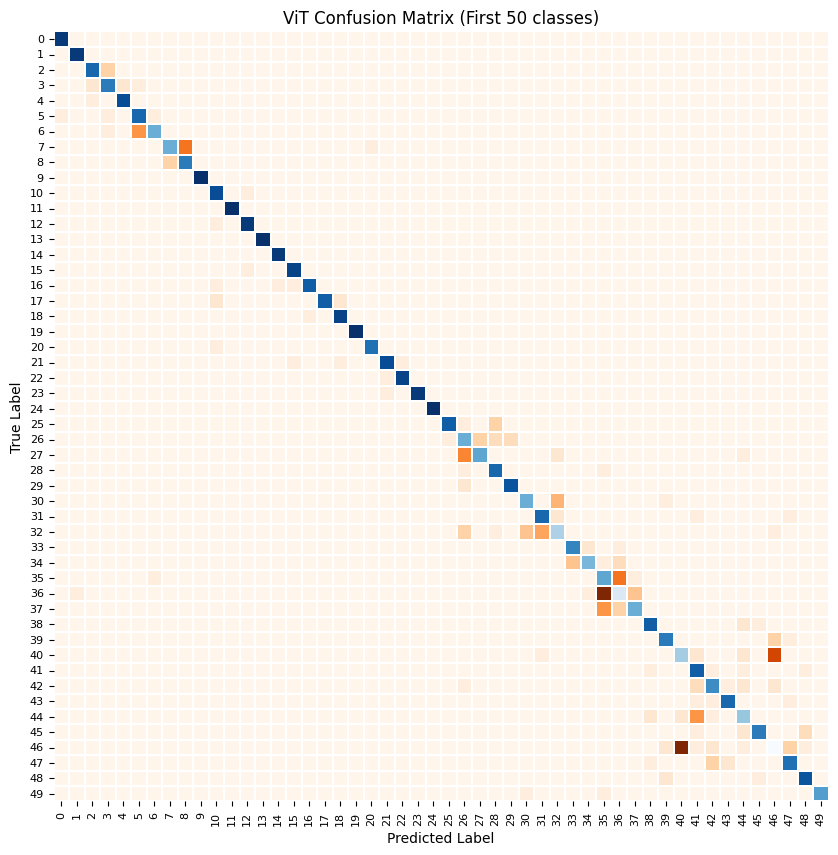

In [78]:


# Select the first 20 classes from the confusion matrix
num_classes_to_plot = 50
skip = 1
cm_vit_filtered = cm_vit[:num_classes_to_plot:skip, :num_classes_to_plot:skip]

# Create a mask to distinguish between correct and incorrect predictions
mask_correct = np.eye(cm_vit_filtered.shape[0], dtype=bool)

# Create a custom colormap
cmap = sns.color_palette(["#d4f7d4", "#f7d4d4"])  # Green for correct, red for incorrect

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(
    cm_vit_filtered,
    annot=False,
    fmt="d",
    cmap="Blues",  # Use the custom colormap
    xticklabels=class_names[:num_classes_to_plot:skip],
    yticklabels=class_names[:num_classes_to_plot:skip],
    mask=~mask_correct,  # Highlight correct predictions
    cbar=False
)
sns.heatmap(
    cm_vit_filtered,
    annot=False,
    fmt="",
    cmap="Oranges",  # Highlight incorrect predictions
    xticklabels=class_names[:num_classes_to_plot:skip],
    yticklabels=class_names[:num_classes_to_plot:skip],
    mask=mask_correct,  # Ignore correct predictions
    cbar=False,
    linewidths=0.1,
)

# Labels and title
plt.title("ViT Confusion Matrix (First 50 classes)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()


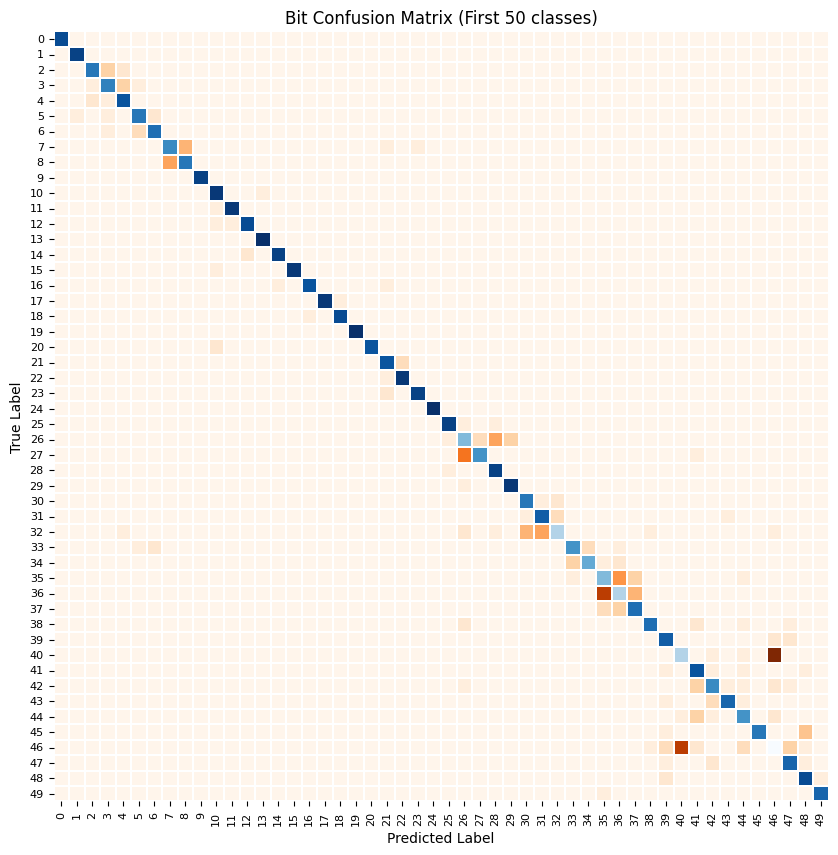

In [79]:


# Select the first 20 classes from the confusion matrix
num_classes_to_plot = 50
skip = 1
cm_bit_filtered = cm_bit[:num_classes_to_plot:skip, :num_classes_to_plot:skip]

# Create a mask to distinguish between correct and incorrect predictions
mask_correct = np.eye(cm_bit_filtered.shape[0], dtype=bool)

# Create a custom colormap
cmap = sns.color_palette(["#d4f7d4", "#f7d4d4"])  # Green for correct, red for incorrect

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(
    cm_bit_filtered,
    annot=False,
    fmt="d",
    cmap="Blues",  # Use the custom colormap
    xticklabels=class_names[:num_classes_to_plot:skip],
    yticklabels=class_names[:num_classes_to_plot:skip],
    mask=~mask_correct,  # Highlight correct predictions
    cbar=False
)
sns.heatmap(
    cm_bit_filtered,
    annot=False,
    fmt="",
    cmap="Oranges",  # Highlight incorrect predictions
    xticklabels=class_names[:num_classes_to_plot:skip],
    yticklabels=class_names[:num_classes_to_plot:skip],
    mask=mask_correct,  # Ignore correct predictions
    cbar=False,
    linewidths=0.1,
)

# Labels and title
plt.title("Bit Confusion Matrix (First 50 classes)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()


ViT Accuracy: 80.32%
Time taken: 439.34s

BiT Accuracy: 80.36%
Time taken: 949.60s



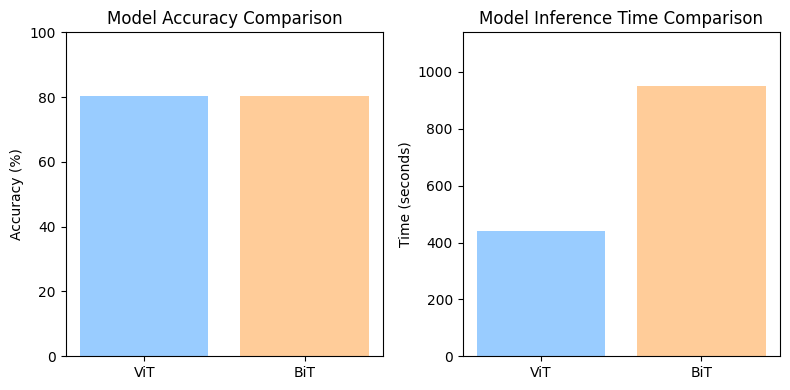

In [80]:
_, _, vit_accuracy, vit_time_taken = load_model_data('Model_Data/vit_imagenet.pkl')
_, _, bit_accuracy, bit_time_taken = load_model_data('Model_Data/bit_imagenet.pkl')
# Model names
models = ['ViT', 'BiT']

# Accuracy and time taken values
accuracies = [vit_accuracy * 100, bit_accuracy * 100]
times_taken = [vit_time_taken, bit_time_taken]


# Display results
for model, acc, time in zip(['ViT', 'BiT'], [vit_accuracy * 100, bit_accuracy * 100], [vit_time_taken, bit_time_taken]):
    print(f"{model} Accuracy: {acc:.2f}%\nTime taken: {time:.2f}s\n")

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
for i, (data, title, ylabel, ylim) in enumerate(zip([[vit_accuracy * 100, bit_accuracy * 100], [vit_time_taken, bit_time_taken]],
                                                   ['Model Accuracy Comparison', 'Model Inference Time Comparison'],
                                                   ['Accuracy (%)', 'Time (seconds)'],
                                                   [100, max([vit_time_taken, bit_time_taken]) * 1.2])):
    ax[i].bar(['ViT', 'BiT'], data, color=['#99CCFF', '#FFCC99'])
    ax[i].set_title(title)
    ax[i].set_ylabel(ylabel)
    ax[i].set_ylim(0, ylim)

plt.tight_layout()
plt.show()

## References
ImageNet on Kaggle - https://www.kaggle.com/c/imagenet-object-localization-challenge/overview \
ILSVRC2012 paper - https://arxiv.org/pdf/1409.0575 \
Tiny ImageNet on Kaggle - https://www.kaggle.com/datasets/akash2sharma/tiny-imagenet